#Introduction

Here we try to extract seasonality and trend from the time series, in order to remove the noise.

We did others 7 attempts varing the window size, others changing the learning rate and others modifying the batch size, all of them resulted in worse performances.

# Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/MyDrive/Challenge2_Mio

/gdrive/MyDrive/Challenge2_Mio


In [ ]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=62ff7e89eebb65841a2f0ecec9df901b47405671ad16d0e731b004c9166225b2
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


# Import libraries

In [ ]:
title = 'Seasonality_v1' #used to save models and checkpoint. Assumes in the current folder, you have a folder called "Models"

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis (EDA)


Load the dataset

In [ ]:
dataset = pd.read_csv('Training.csv')
# Add a date to use the seasonal_decompose module which requires a date for the points
dataset['date'] = pd.date_range(start='1/1/1979', periods=len(dataset), freq='D')
# Convert daily column from just string to DateTime
dataset['date'] = pd.to_datetime(dataset['date'])
# Set the column 'Date' as index 
dataset = dataset.set_index('date')
# Specify datetime frequency
dataset = dataset.asfreq('D')
dataset2 = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
date,,,,,,,
1979-01-01,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1979-01-02,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
1979-01-03,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
1979-01-04,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
1979-01-05,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68528 entries, 1979-01-01 to 2166-08-15
Freq: D
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 4.2 MB


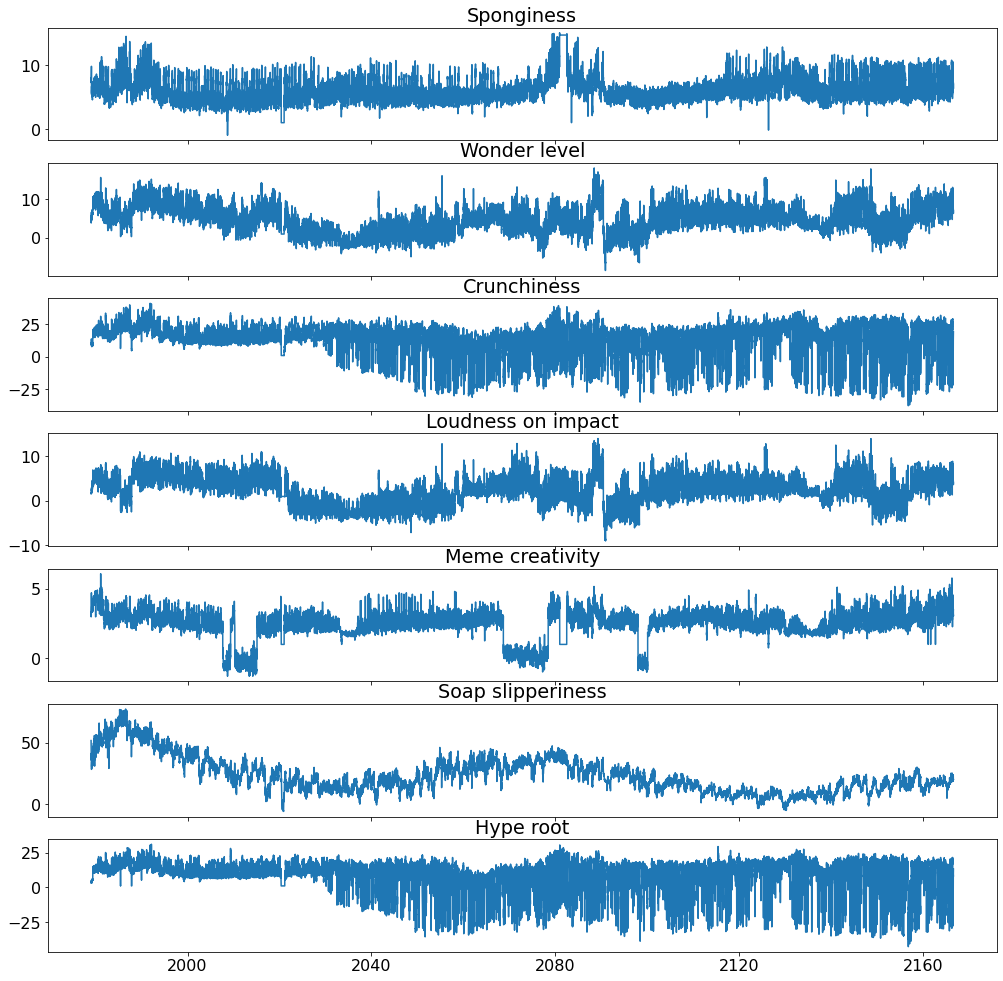

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

In [ ]:
print((dataset.shape))

(68528, 7)


(63528, 7) (5000, 7)


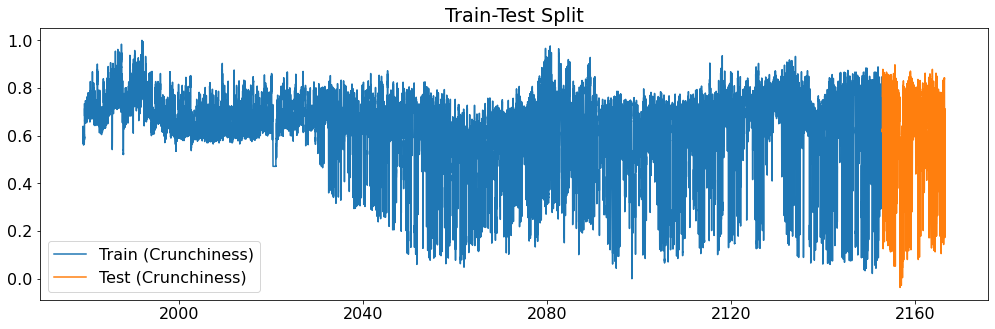

In [ ]:
test_size = 5000
X_train_raw = dataset.iloc[:-test_size]
# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]

# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness, label='Train (Crunchiness)')
plt.plot(X_test_raw.Crunchiness, label='Test (Crunchiness)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
print('X_min')
print(X_min)
print('X_max')
print(X_max)

X_min
Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -34.802881
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -38.816760
dtype: float64
X_max
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


In [ ]:
direct_window = 90
direct_stride = 5
ar_window = 90
ar_stride = 5
general_telescope = 864

In [ ]:
# Decompose signal in trand+seasonality+noise

from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(X_train_raw, model="additive", extrapolate_trend='freq')

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

In [ ]:
# We keep just the seasonality and the trend for the training

X_train_raw = seasonal+trend

# Plot decomposed time series

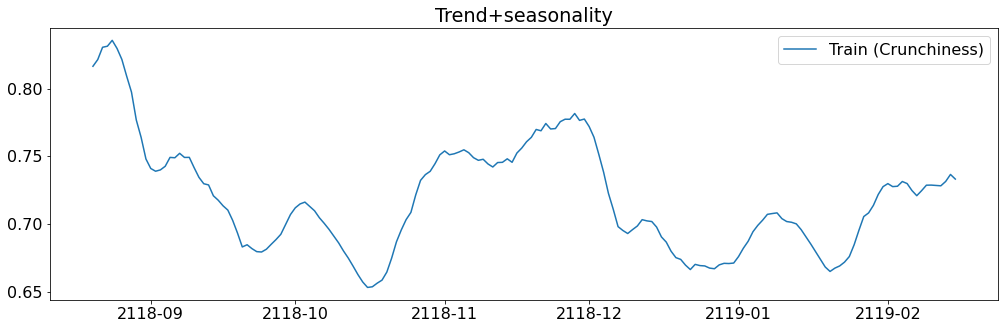

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Crunchiness[51000:51180], label='Train (Crunchiness)')
plt.title('Trend+seasonality')
plt.legend()
plt.show()

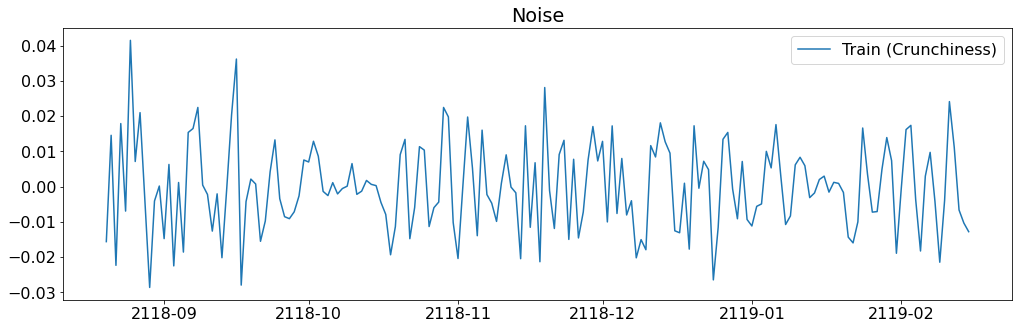

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(residual.Crunchiness[51000:51180], label='Train (Crunchiness)')
plt.title('Noise')
plt.legend()
plt.show()

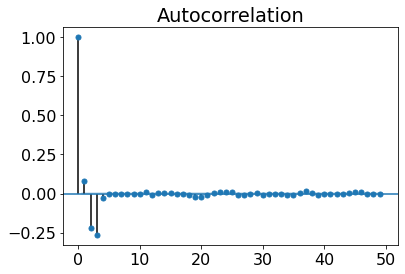

In [ ]:
# Example of autocorrelation on noise, which is not a white noise, but we treat it as it is

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residual.Crunchiness)
plt.show()

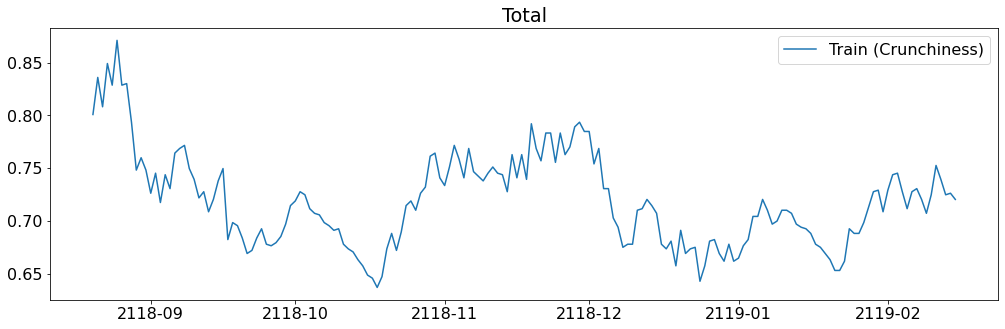

In [ ]:
# Trend+Seasonality+Noise
plt.figure(figsize=(17,5))
plt.plot(residual.Crunchiness[51000:51180]+X_train_raw.Crunchiness[51000:51180], label='Train (Crunchiness)')
plt.title('Total')
plt.legend()
plt.show()

In [ ]:
print(X_test_raw.shape)

(5000, 7)


In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=864):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

# Utility functions

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Check')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_rmse', mode='min', patience=30, restore_best_weights=True),
  callbacks.append(es_callback)
  es2_callback = tfk.callbacks.ReduceLROnPlateau(monitor='val_rmse', mode='min', patience=5, factor=0.5, min_lr=1e-5)
  callbacks.append(es2_callback)

  return callbacks

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_LSTM_model(input_shape, output_shape):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    attention = SeqSelfAttention(attention_activation='sigmoid')(lstm)
    gap = tfkl.GlobalAveragePooling1D()(attention)
    dense = tfkl.Dense(output_shape[0]*output_shape[1], activation='relu')(gap)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    # Connect input and output through the Model class
    full_model = tfk.Model(inputs=input_layer, outputs=output_layer)
    # Compile the model
    full_model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(learning_rate=0.0005), metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    # Return the model
    return full_model

In [ ]:
target_labels = dataset.columns
telescope = 864

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, ar_window, ar_stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, ar_window, ar_stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12518, 90, 7), (12518, 864, 7), (818, 90, 7), (818, 864, 7))

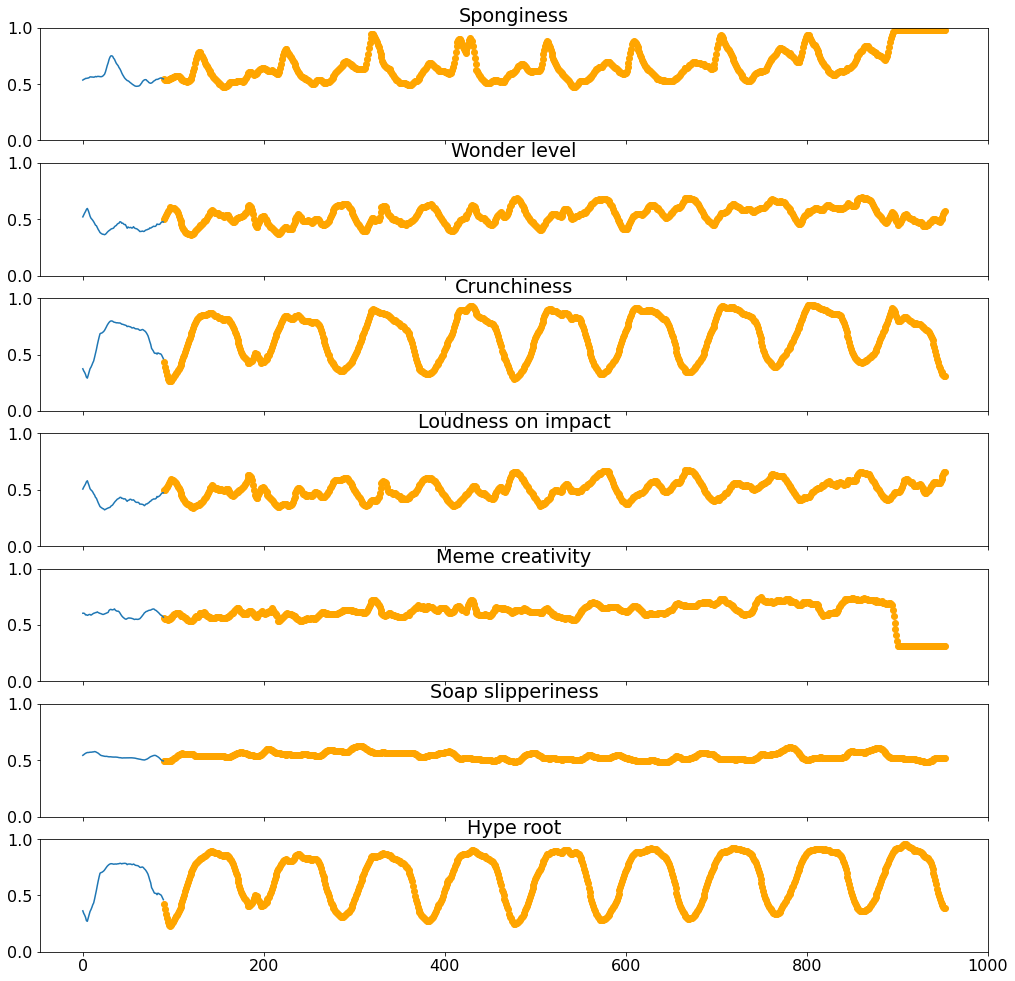

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 8
epochs = 500

In [ ]:
print(input_shape, output_shape)

(90, 7) (864, 7)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 90, 7)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 90, 256)          139264    
 l)                                                              
                                                                 
 seq_self_attention (SeqSelf  (None, 90, 256)          16449     
 Attention)                                                      
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6048)              1554336   
                                                             

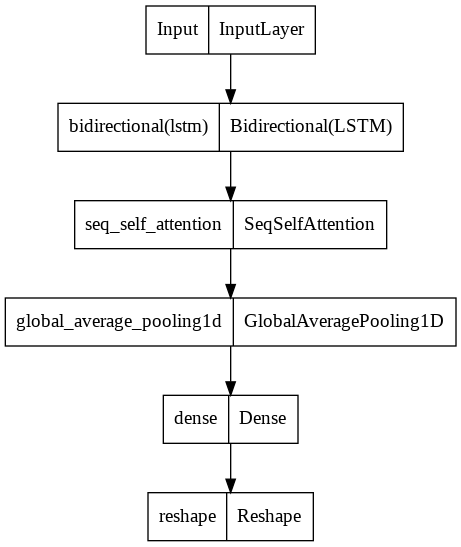

In [ ]:
model = build_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

# Training and testing

In [ ]:
# Create folders and callbacks and fit
cbs = create_folders_and_callbacks(model_name = title) #the model name will generate the folder of this single experiment

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = cbs
).history

Epoch 1/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0674 - mae: 0.1672 - rmse: 0.2597

1409/1409 [==============================] - 41s 27ms/step - loss: 0.0674 - mae: 0.1672 - rmse: 0.2597 - val_loss: 0.0363 - val_mae: 0.1191 - val_rmse: 0.1905 - lr: 5.0000e-04
Epoch 2/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0265 - mae: 0.0967 - rmse: 0.1627

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0265 - mae: 0.0967 - rmse: 0.1627 - val_loss: 0.0240 - val_mae: 0.0989 - val_rmse: 0.1548 - lr: 5.0000e-04
Epoch 3/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0179 - mae: 0.0807 - rmse: 0.1337

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0179 - mae: 0.0807 - rmse: 0.1337 - val_loss: 0.0190 - val_mae: 0.0909 - val_rmse: 0.1378 - lr: 5.0000e-04
Epoch 4/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0136 - mae: 0.0727 - rmse: 0.1166

1409/1409 [==============================] - 32s 22ms/step - loss: 0.0136 - mae: 0.0727 - rmse: 0.1166 - val_loss: 0.0163 - val_mae: 0.0864 - val_rmse: 0.1275 - lr: 5.0000e-04
Epoch 5/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0112 - mae: 0.0678 - rmse: 0.1059

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0112 - mae: 0.0678 - rmse: 0.1059 - val_loss: 0.0147 - val_mae: 0.0838 - val_rmse: 0.1212 - lr: 5.0000e-04
Epoch 6/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0099 - mae: 0.0649 - rmse: 0.0995

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0099 - mae: 0.0649 - rmse: 0.0995 - val_loss: 0.0149 - val_mae: 0.0850 - val_rmse: 0.1221 - lr: 5.0000e-04
Epoch 7/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0090 - mae: 0.0627 - rmse: 0.0946

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0090 - mae: 0.0627 - rmse: 0.0946 - val_loss: 0.0138 - val_mae: 0.0827 - val_rmse: 0.1176 - lr: 5.0000e-04
Epoch 8/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0085 - mae: 0.0613 - rmse: 0.0920

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0085 - mae: 0.0613 - rmse: 0.0920 - val_loss: 0.0135 - val_mae: 0.0828 - val_rmse: 0.1162 - lr: 5.0000e-04
Epoch 9/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0078 - mae: 0.0595 - rmse: 0.0882

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0078 - mae: 0.0595 - rmse: 0.0882 - val_loss: 0.0139 - val_mae: 0.0852 - val_rmse: 0.1178 - lr: 5.0000e-04
Epoch 10/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0071 - mae: 0.0578 - rmse: 0.0840

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0071 - mae: 0.0578 - rmse: 0.0840 - val_loss: 0.0126 - val_mae: 0.0798 - val_rmse: 0.1120 - lr: 5.0000e-04
Epoch 11/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0066 - mae: 0.0567 - rmse: 0.0814

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0066 - mae: 0.0567 - rmse: 0.0814 - val_loss: 0.0127 - val_mae: 0.0811 - val_rmse: 0.1127 - lr: 5.0000e-04
Epoch 12/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0065 - mae: 0.0561 - rmse: 0.0806

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0065 - mae: 0.0561 - rmse: 0.0806 - val_loss: 0.0118 - val_mae: 0.0777 - val_rmse: 0.1086 - lr: 5.0000e-04
Epoch 13/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0553 - rmse: 0.0793

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0063 - mae: 0.0553 - rmse: 0.0793 - val_loss: 0.0113 - val_mae: 0.0777 - val_rmse: 0.1063 - lr: 5.0000e-04
Epoch 14/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0061 - mae: 0.0544 - rmse: 0.0778

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0061 - mae: 0.0544 - rmse: 0.0778 - val_loss: 0.0122 - val_mae: 0.0798 - val_rmse: 0.1103 - lr: 5.0000e-04
Epoch 15/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0059 - mae: 0.0542 - rmse: 0.0771

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0059 - mae: 0.0542 - rmse: 0.0771 - val_loss: 0.0115 - val_mae: 0.0781 - val_rmse: 0.1074 - lr: 5.0000e-04
Epoch 16/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0058 - mae: 0.0536 - rmse: 0.0761

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0058 - mae: 0.0536 - rmse: 0.0761 - val_loss: 0.0118 - val_mae: 0.0787 - val_rmse: 0.1088 - lr: 5.0000e-04
Epoch 17/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0056 - mae: 0.0528 - rmse: 0.0746

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0056 - mae: 0.0528 - rmse: 0.0746 - val_loss: 0.0112 - val_mae: 0.0775 - val_rmse: 0.1058 - lr: 5.0000e-04
Epoch 18/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0055 - mae: 0.0525 - rmse: 0.0739

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0055 - mae: 0.0525 - rmse: 0.0739 - val_loss: 0.0118 - val_mae: 0.0790 - val_rmse: 0.1086 - lr: 5.0000e-04
Epoch 19/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0052 - mae: 0.0514 - rmse: 0.0723

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0052 - mae: 0.0514 - rmse: 0.0723 - val_loss: 0.0117 - val_mae: 0.0792 - val_rmse: 0.1082 - lr: 5.0000e-04
Epoch 20/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0053 - mae: 0.0515 - rmse: 0.0726

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0053 - mae: 0.0516 - rmse: 0.0726 - val_loss: 0.0119 - val_mae: 0.0782 - val_rmse: 0.1089 - lr: 5.0000e-04
Epoch 21/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0051 - mae: 0.0507 - rmse: 0.0712

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0051 - mae: 0.0507 - rmse: 0.0712 - val_loss: 0.0118 - val_mae: 0.0797 - val_rmse: 0.1087 - lr: 5.0000e-04
Epoch 22/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0050 - mae: 0.0503 - rmse: 0.0705

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0050 - mae: 0.0503 - rmse: 0.0705 - val_loss: 0.0113 - val_mae: 0.0779 - val_rmse: 0.1064 - lr: 5.0000e-04
Epoch 23/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0045 - mae: 0.0478 - rmse: 0.0672

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0045 - mae: 0.0478 - rmse: 0.0672 - val_loss: 0.0119 - val_mae: 0.0794 - val_rmse: 0.1089 - lr: 2.5000e-04
Epoch 24/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0664

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0664 - val_loss: 0.0119 - val_mae: 0.0789 - val_rmse: 0.1090 - lr: 2.5000e-04
Epoch 25/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0044 - mae: 0.0471 - rmse: 0.0661

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0044 - mae: 0.0471 - rmse: 0.0661 - val_loss: 0.0119 - val_mae: 0.0800 - val_rmse: 0.1091 - lr: 2.5000e-04
Epoch 26/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0044 - mae: 0.0473 - rmse: 0.0664

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0044 - mae: 0.0473 - rmse: 0.0664 - val_loss: 0.0116 - val_mae: 0.0788 - val_rmse: 0.1078 - lr: 2.5000e-04
Epoch 27/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0467 - rmse: 0.0654

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0043 - mae: 0.0467 - rmse: 0.0654 - val_loss: 0.0119 - val_mae: 0.0797 - val_rmse: 0.1092 - lr: 2.5000e-04
Epoch 28/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0452 - rmse: 0.0634

1409/1409 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0452 - rmse: 0.0634 - val_loss: 0.0117 - val_mae: 0.0792 - val_rmse: 0.1081 - lr: 1.2500e-04
Epoch 29/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0040 - mae: 0.0451 - rmse: 0.0631

1409/1409 [==============================] - 30s 22ms/step - loss: 0.0040 - mae: 0.0451 - rmse: 0.0631 - val_loss: 0.0121 - val_mae: 0.0797 - val_rmse: 0.1098 - lr: 1.2500e-04
Epoch 30/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0040 - mae: 0.0449 - rmse: 0.0629

1409/1409 [==============================] - 31s 22ms/step - loss: 0.0040 - mae: 0.0449 - rmse: 0.0629 - val_loss: 0.0119 - val_mae: 0.0796 - val_rmse: 0.1092 - lr: 1.2500e-04
Epoch 31/500
1406/1409 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0448 - rmse: 0.0627

1409/1409 [==============================] - 31s 22ms/step - loss: 0.0039 - mae: 0.0448 - rmse: 0.0627 - val_loss: 0.0122 - val_mae: 0.0804 - val_rmse: 0.1104 - lr: 1.2500e-04
Epoch 32/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0039 - mae: 0.0446 - rmse: 0.0623

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0039 - mae: 0.0446 - rmse: 0.0623 - val_loss: 0.0118 - val_mae: 0.0794 - val_rmse: 0.1088 - lr: 1.2500e-04
Epoch 33/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0038 - mae: 0.0440 - rmse: 0.0615

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0038 - mae: 0.0440 - rmse: 0.0615 - val_loss: 0.0120 - val_mae: 0.0797 - val_rmse: 0.1095 - lr: 6.2500e-05
Epoch 34/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0438 - rmse: 0.0612

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0037 - mae: 0.0438 - rmse: 0.0612 - val_loss: 0.0121 - val_mae: 0.0801 - val_rmse: 0.1099 - lr: 6.2500e-05
Epoch 35/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0037 - mae: 0.0437 - rmse: 0.0611

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0037 - mae: 0.0437 - rmse: 0.0611 - val_loss: 0.0121 - val_mae: 0.0800 - val_rmse: 0.1098 - lr: 6.2500e-05
Epoch 36/500
1407/1409 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0436 - rmse: 0.0610

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0037 - mae: 0.0436 - rmse: 0.0610 - val_loss: 0.0122 - val_mae: 0.0805 - val_rmse: 0.1103 - lr: 6.2500e-05
Epoch 37/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0037 - mae: 0.0435 - rmse: 0.0608

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0037 - mae: 0.0435 - rmse: 0.0608 - val_loss: 0.0121 - val_mae: 0.0801 - val_rmse: 0.1098 - lr: 6.2500e-05
Epoch 38/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0432 - rmse: 0.0603

1409/1409 [==============================] - 30s 22ms/step - loss: 0.0036 - mae: 0.0432 - rmse: 0.0604 - val_loss: 0.0120 - val_mae: 0.0800 - val_rmse: 0.1097 - lr: 3.1250e-05
Epoch 39/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0431 - rmse: 0.0602

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0036 - mae: 0.0431 - rmse: 0.0602 - val_loss: 0.0121 - val_mae: 0.0805 - val_rmse: 0.1102 - lr: 3.1250e-05
Epoch 40/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0431 - rmse: 0.0601

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0036 - mae: 0.0431 - rmse: 0.0601 - val_loss: 0.0122 - val_mae: 0.0808 - val_rmse: 0.1103 - lr: 3.1250e-05
Epoch 41/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0430 - rmse: 0.0601

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0036 - mae: 0.0430 - rmse: 0.0601 - val_loss: 0.0121 - val_mae: 0.0804 - val_rmse: 0.1101 - lr: 3.1250e-05
Epoch 42/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0430 - rmse: 0.0600

1409/1409 [==============================] - 29s 20ms/step - loss: 0.0036 - mae: 0.0430 - rmse: 0.0600 - val_loss: 0.0122 - val_mae: 0.0807 - val_rmse: 0.1104 - lr: 3.1250e-05
Epoch 43/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0428 - rmse: 0.0598

1409/1409 [==============================] - 30s 21ms/step - loss: 0.0036 - mae: 0.0428 - rmse: 0.0598 - val_loss: 0.0121 - val_mae: 0.0805 - val_rmse: 0.1102 - lr: 1.5625e-05
Epoch 44/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0428 - rmse: 0.0597

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0036 - mae: 0.0428 - rmse: 0.0597 - val_loss: 0.0121 - val_mae: 0.0805 - val_rmse: 0.1101 - lr: 1.5625e-05
Epoch 45/500
1409/1409 [==============================] - ETA: 0s - loss: 0.0036 - mae: 0.0428 - rmse: 0.0597

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0036 - mae: 0.0428 - rmse: 0.0597 - val_loss: 0.0121 - val_mae: 0.0805 - val_rmse: 0.1102 - lr: 1.5625e-05
Epoch 46/500
1408/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0427 - rmse: 0.0597

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0036 - mae: 0.0427 - rmse: 0.0597 - val_loss: 0.0121 - val_mae: 0.0803 - val_rmse: 0.1099 - lr: 1.5625e-05
Epoch 47/500
1405/1409 [============================>.] - ETA: 0s - loss: 0.0036 - mae: 0.0427 - rmse: 0.0596

1409/1409 [==============================] - 29s 21ms/step - loss: 0.0036 - mae: 0.0427 - rmse: 0.0596 - val_loss: 0.0121 - val_mae: 0.0807 - val_rmse: 0.1102 - lr: 1.5625e-05


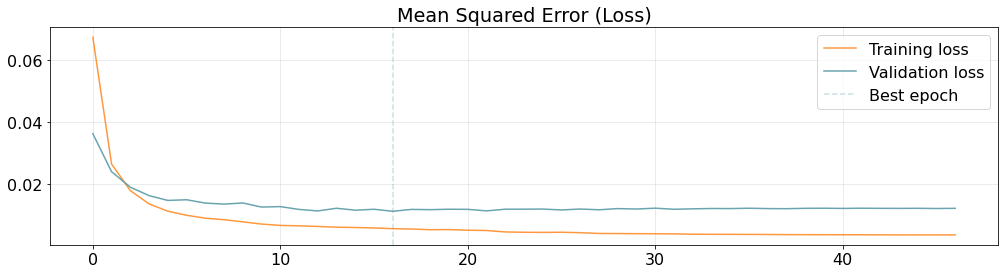

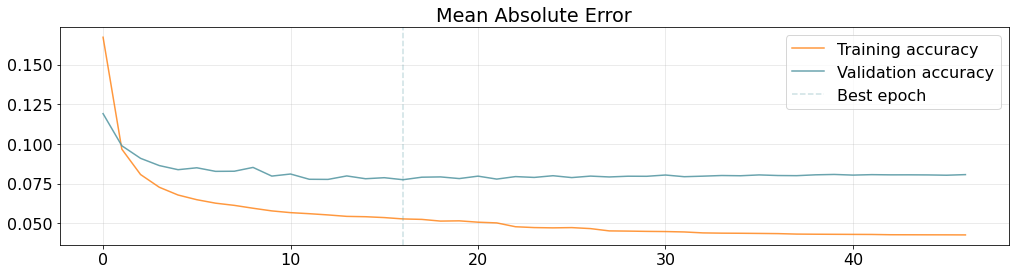

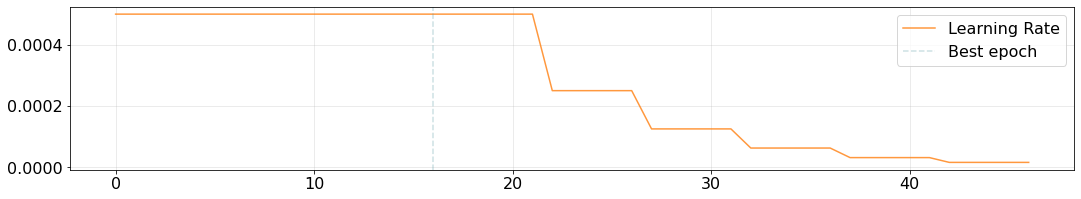

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#model.save('Models/'+title)
model = tfk.models.load_model('Models/'+title)

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(818, 864, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.013411711>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.087174356>)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

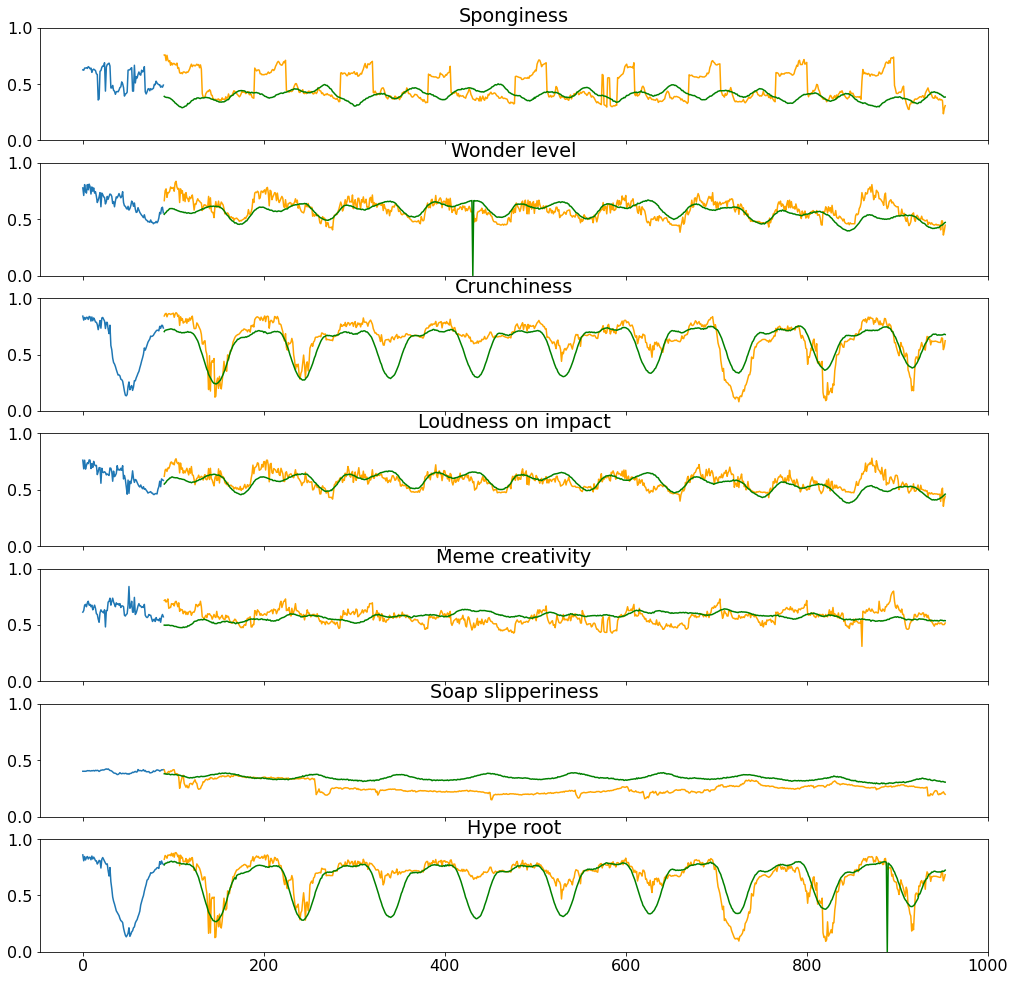

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)